In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa

from shapely.geometry import box

import matplotlib.pyplot as plt
import contextily as ctx

In [24]:
import contextlib

def parse_par(par_fp):
    with open(par_fp, 'r') as f:
        lns = f.readlines()
    par = {l.split()[0].strip(':'):l.split()[1] for l in lns if len(l) > 2}

    for k, v in par.items():
        try: par[k] = float(v)
        except: par[k] = v
    return par

def get_width(par):
    cols = [k for k in par.keys() if ('range_samp' in k) or ('width' in k)]
    width = par[cols[0]]
    return width

def gamma_to_numpy(fp, par_fp):
    par = parse_par(par_fp)
    width = get_width(par)
    arr = np.fromfile(fp, '>f4').reshape(-1, int(width))

    return arr, par

def gamma_to_xarray(fp, par_fp):
    arr, par = gamma_to_numpy(fp, par_fp)
    dx, dy = par['post_lon'], par['post_lat']
    xs = np.linspace(par['corner_lon'], par['corner_lon'] + dx* arr.shape[1], arr.shape[1])
    ys = np.linspace(par['corner_lat'], par['corner_lat'] + dy* arr.shape[0], arr.shape[0])
    da = xr.DataArray(arr, dims = {'x', 'y'}, coords = {'y': ys, 'x': xs})
    return da.where((da > 0) & (da < 1)).dropna('x', how = 'all').dropna('y', how = 'all')

In [91]:
gdf = gpd.read_file('/Users/rdcrlzh1/Documents/arctic-radarsat2/data/FY24_OLI_UTQ_rsgis_coherance_aois/FY24_OLI_UTQ_rsgis_coherance_aois.shp')
gdf = gdf[gdf.Location == 'Oliktok']

s1s = {fp.stem: xr.open_dataarray(fp).squeeze('band', drop = True)/100 for fp in  list(Path('/Users/rdcrlzh1/Documents/arctic-radarsat2/data/s1/Oliktok').glob('*.tif'))}
r2s = {fp.stem.replace('.cor', ''): gamma_to_xarray(fp, fp.parent.parent.joinpath('processing', 'Oliktok').with_suffix('.dem_par')) for fp in list(Path('/Users/rdcrlzh1/Documents/arctic-radarsat2/data/Oliktok/SLA16').rglob('*.cor.geo'))}
r2s = {stem: ds.expand_dims(time1 = [pd.to_datetime(stem.split('_')[0])], time2 = [pd.to_datetime(stem.split('_')[1])],) for stem, ds in r2s.items() if (pd.to_datetime(stem.split('_')[1]) - pd.to_datetime(stem.split('_')[0])).days == 24}

In [87]:
concat_ds =[]
for i, ds in enumerate(list(r2s.values())):
    t1, t2 = ds.time1, ds.time2
    ds = ds.rio.write_crs('EPSG:4326').isel(time1 = 0, time2 = 0)
    if i != 0:
        ds = ds.rio.reproject_match(concat_ds[0])
    ds = ds.where((ds < 1) & (ds > 0))
    concat_ds.append(ds.expand_dims(time1 = t1, time2 = t2))
rs2_med = xr.combine_by_coords(concat_ds).median(['time1', 'time2'])

In [99]:
gdf[gdf.Location == 'Oliktok'].total_bounds

array([-149.89514923,   70.48816221, -149.87095963,   70.49691451])

/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Users/rdcrlzh1/miniforge3/envs/science/lib/py

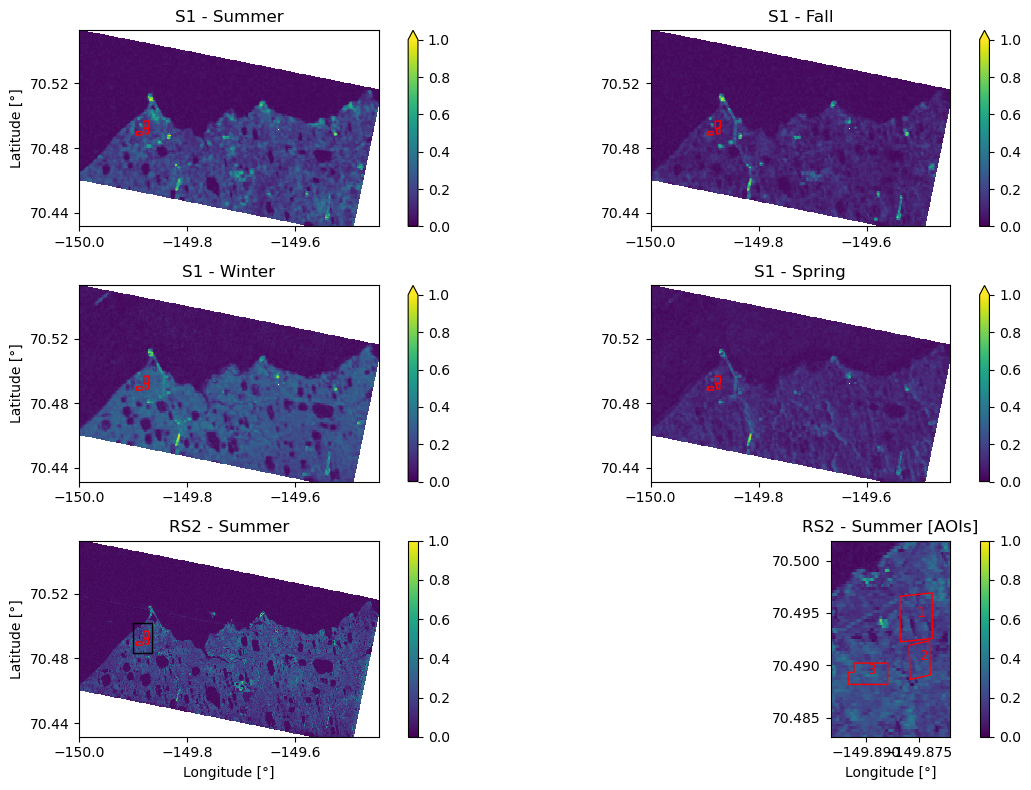

In [119]:
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

fig, axes = plt.subplots(3, 2, figsize = (12, 8))
for season, ax in zip(['summer', 'fall', 'winter' ,'spring'], axes[:4].ravel()):
    s1s[f'N71W150_{season}_vv_COH24'].rio.reproject_match(rs2_med).where(~rs2_med.isnull()).plot(ax  = ax, vmin = 0, vmax = 1, cbar_kwargs = {'label': ''})
    ax.set_title(f'S1 - {season.capitalize()}')
    # ax.set_xlim(rs2_med.x.min().data.ravel()[0], rs2_med.x.max().data.ravel()[0])
    # ax.set_ylim(rs2_med.y.min().data.ravel()[0], rs2_med.y.max().data.ravel()[0])
rs2_med.plot(ax = axes[2, 0], vmin = 0, vmax = 1, cbar_kwargs = {'label': ''})
axes[2, 0].set_title('RS2 - Summer')
rs2_med.plot(ax = axes[2, 1], vmin = 0, vmax = 1, cbar_kwargs = {'label': ''})
axes[2, 1].set_title('RS2 - Summer [AOIs]')


for ax in axes.ravel():
    gdf[gdf.Location == 'Oliktok'].plot(ax = ax, facecolor = "none", edgecolor = 'red')
    ax.set_xlim(left= -150)
    ax.ticklabel_format(axis = 'both', style = 'plain', useOffset = False)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

for ax in axes[:2,:].ravel(): ax.set_xlabel('')
for ax in axes[:,1].ravel(): ax.set_ylabel('')
for ax in axes[:,0].ravel(): ax.set_ylabel('Latitude [°]')
for ax in axes[2,:].ravel(): ax.set_xlabel('Longitude [°]')


bds = gdf[gdf.Location == 'Oliktok'].total_bounds
tol = 0.005
axes[2,1].set_xlim(bds[0] - tol, bds[2] + tol)
axes[2,1].set_ylim(bds[1] - tol, bds[3] + tol)

xmin, ymin, xmax, ymax = gdf[gdf.Location == 'Oliktok'].total_bounds
buff = 0.005
width = (xmax + buff) - (xmin - buff)
height = (ymax + buff) - (ymin - buff)
rect = patches.Rectangle((xmin - buff, ymin - buff), width, height, linewidth=1, edgecolor='black', facecolor='none')
axes[2,0].add_patch(rect)
# con1 = ConnectionPatch(xyA=(xmin - buff, ymin - buff), xyB=(xmin - buff, ymax + buff), coordsA="data", coordsB="data", axesA=axes[2,0], axesB=axes[2,1], color="black")
# axes[2,0].add_artist(con1)
# con1 = ConnectionPatch(xyA=(xmax + buff, ymin - buff), xyB=(xmax + buff, ymax + buff), coordsA="data", coordsB="data", axesA=axes[2,0], axesB=axes[2,1], color="black")
# axes[2,0].add_artist(con1)

for i, r in gdf[gdf.Location == 'Oliktok'].iterrows():
    xmin, ymin, xmax, ymax = r.geometry.bounds
    xc, yc = (xmax + xmin) /2  , (ymin + ymax) / 2
    axes[2, 1].text(xc, yc, r.Priority, color = 'red')

plt.tight_layout()